# Tensorflow 4

Notes from 12/04/2018 lecture

## Regularization with early stopping

- Evaluate the model on a validation set at regular interval of epochs
- Store the current best performin model (on validation)
- Stop if the best stored model is not changed for many epochs
- Use the saved model

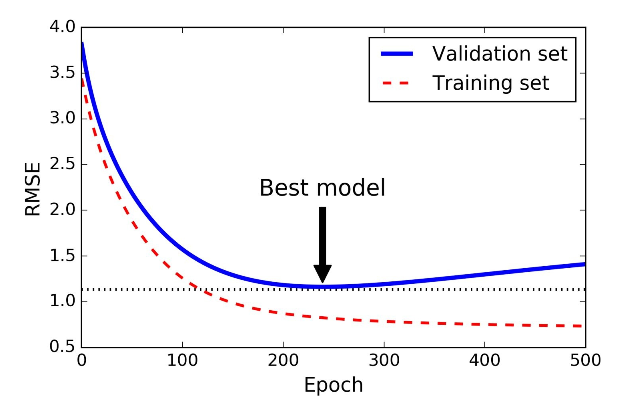

## Regualarization with extended loss

Uses L1 and L2 regularization
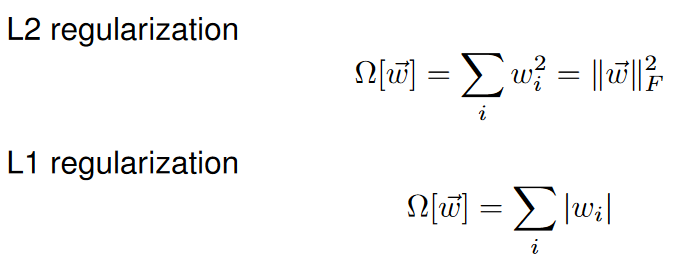

In [3]:
import tensorflow as tf
import numpy as np
from functools import partial
from datetime import datetime

tf.reset_default_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
logdir2 = "{}/run2-{}/".format(root_logdir, now)

# load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/") # download files
# define layers dimensions
n_inputs = 28*28  # MNIST image sizen_hidden1 = 300
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# regularization hyperparameter: Loss + lambda_parameter * regularization  
lambda_parameter = 0.003

# define dense layer with L1 regularization
# the PARTIAL() is used for partial function application which "freezes" 
# some portion of a function's arguments and/or keywords resulting in a 
# new object with a simplified signature

# L1
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_regularizer(lambda_parameter))

# L2
# my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(lambda_parameter))

# build the network (with no soft-max, that will be inserted in the definition of loss)                                                        
with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None, name="outputs")

# build the loss: single label multi-class classification -> softmax in output + cross entropy loss 
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    # add the regularization losses to the base loss:
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy") 
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

# build the subgraph for computing the gradient 
learning_rate = 0.01

with tf.name_scope("train"):
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
    training_op = optimizer.minimize(loss)
# define how to evaluate the model
with tf.name_scope("eval"):
    # check if the highest logit corresponds to the target class
    correct = tf.nn.in_top_k(logits, y, 1) # returns a 1D tensor
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # average to compute accuracy 

init = tf.global_variables_initializer()

acc_summary = tf.summary.scalar('ACC Test', accuracy)
file_writer_1 = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer_2 = tf.summary.FileWriter(logdir2, tf.get_default_graph())

saver = tf.train.Saver()

n_epochs = 40
batch_size = 50

# open session
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
        summary_str = acc_summary.eval(feed_dict={X: X_batch, y: y_batch})
        file_writer_1.add_summary(summary_str,epoch)
        file_writer_1.flush()
        summary_str = acc_summary.eval(feed_dict={X: mnist.validation.images,y: mnist.validation.labels})
        file_writer_2.add_summary(summary_str,epoch)
        file_writer_2.flush()

    save_path = saver.save(sess, "./my_model_final.ckpt")

file_writer_1.close()
file_writer_2.close()



Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Summary name ACC Test is illegal; using ACC_Test instead.
0 Train accuracy: 0.96 Val accuracy: 0.887
1 Train accuracy: 0.98 Val accuracy: 0.893
2 Train accuracy: 0.92 Val accuracy: 0.8964
3 Train accuracy: 0.86 Val accuracy: 0.895
4 Train accuracy: 0.9 Val accuracy: 0.9008
5 Train accuracy: 0.88 Val accuracy: 0.8868
6 Train accuracy: 0.92 Val accuracy: 0.9078
7 Train accuracy: 0.92 Val accuracy: 0.8982
8 Train accuracy: 0.92 Val accuracy: 0.8936
9 Train accuracy: 0.92 Val accuracy: 0.8894
10 Train accuracy: 0.96 Val accuracy: 0.9022
11 Train accuracy: 0.92 Val accuracy: 0.8946
12 Train accuracy: 0.88 Val accuracy: 0.8968
13 Train accuracy: 0.86 Val accuracy: 0.881
14 Train accuracy: 0.94 Val accuracy: 0.8948
15 Train accuracy: 0.94 Val accuracy: 0.8978
16 Train accuracy: 0.9 Val accu

## Regularization with Dropout

Do training to choose random units to remove stochastically. Each unit is set to 0 with probability 0.5. In this way they can not co-adapt to other units. Change the way the system viewes the input and let it adapts to a input that can change. Any time the network change.
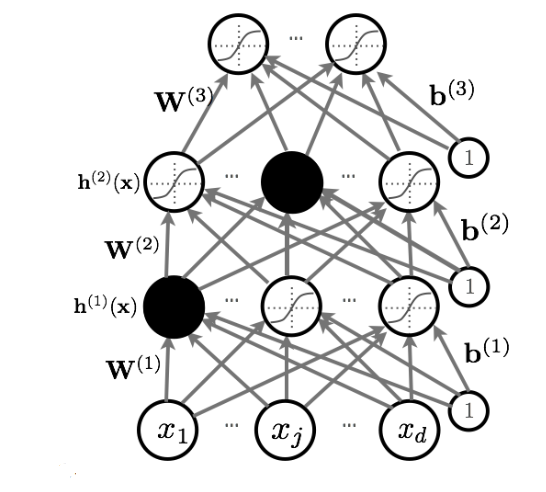
A mask is used every time. At test time however no mask should be used in order to make predictions.
Can be viewed as a geometric average of exponential number of networks.
Dropout is already implemented in Tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import sys
from datetime import datetime

tf.reset_default_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-".format(root_logdir)+sys.argv[1]+"-{}/".format(now)
logdir2 = "{}/run2-".format(root_logdir)+sys.argv[1]+"-{}/".format(now)

# load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/") # download files
# define layers dimensions
n_inputs = 28*28  # MNIST image sizen_hidden1 = 300
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = float(0.5)#sys.argv[1])  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

# build the loss: single label multi-class classification -> softmax in output + cross entropy loss 
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# build the subgraph for computing the gradient 
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
# define how to evaluate the model
with tf.name_scope("eval"):
    # check if the highest logit corresponds to the target class
    correct = tf.nn.in_top_k(logits, y, 1) # returns a 1D tensor
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # average to compute accuracy 

init = tf.global_variables_initializer()

acc_summary = tf.summary.scalar('ACC Test', accuracy)
file_writer_1 = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer_2 = tf.summary.FileWriter(logdir2, tf.get_default_graph())

saver = tf.train.Saver()

n_epochs = 100
batch_size = 50

# open session

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
        summary_str = acc_summary.eval(feed_dict={X: X_batch, y: y_batch})
        file_writer_1.add_summary(summary_str,epoch)
        file_writer_1.flush()
        summary_str = acc_summary.eval(feed_dict={X: mnist.validation.images,y: mnist.validation.labels})
        file_writer_2.add_summary(summary_str,epoch)
        file_writer_2.flush()

    save_path = saver.save(sess, "./my_model_final.ckpt")



## Recurrent neural network

In this example we consider images in MNIST as sequence of rows
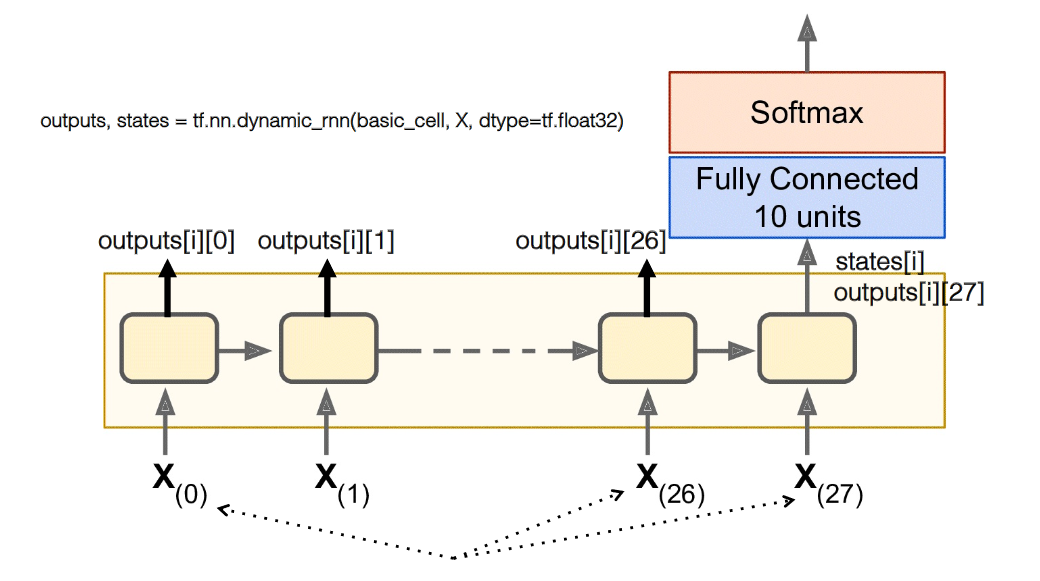

In [6]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

# load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/") # download files

# define dimensions
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_val)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.94 Test accuracy: 0.9172
1 Train accuracy: 0.94 Test accuracy: 0.948
2 Train accuracy: 0.94666666 Test accuracy: 0.9488
3 Train accuracy: 0.98 Test accuracy: 0.9621
4 Train accuracy: 0.98 Test accuracy: 0.9606
5 Train accuracy: 0.9533333 Test accuracy: 0.9646
6 Train accuracy: 0.98 Test accuracy: 0.9715
7 Train accuracy: 0.9866667 Test accuracy: 0.9686
8 Train accuracy: 0.96666664 Test accuracy: 0.9683
9 Train accuracy: 0.98 Test accuracy: 0.9768
10 Train accuracy: 0.9866667 Test accuracy: 0.9736
11 Train accuracy: 0.98 Test accuracy: 0.9672
12 Train accuracy: 0.98 Test accuracy: 0.9775
13 Train accuracy: 0.94666666 Test accuracy: 0.9756
14 Train accuracy: 0.97333336 Test accuracy: 0.9761
15 Train accuracy: 0.99333334 Test accuracy: 0.975
16 Train accuracy: 0.9866667 Test accurac

KeyboardInterrupt: 